In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
#from PIL import Image

device = torch.device('cpu') #cuda

C:\Users\puliyand\AppData\Local\anaconda3\envs\torchenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
import numpy as np
#import tensorflow as tf
from matplotlib import pyplot as plt
# make all the plot settings here
plt.rcParams['figure.dpi'] = 180 # this makes higher resolution figures than the default (78)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 20
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["axes.titlesize"] = "large"
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 12

from sklearn.preprocessing import MinMaxScaler
import scipy.io

scaler = MinMaxScaler()


#add path to the folder containing the pre-processed RMSD data for cellobiose

rmsd_CB100=np.load('RMSD_CB100_vox_v3.npy')
rmsd_CB100 = scaler.fit_transform(rmsd_CB100.reshape(-1, 1))

rmsd_CB500=np.load('RMSD_CB500_vox_v3.npy')
rmsd_CB500 = scaler.fit_transform(rmsd_CB500.reshape(-1, 1))

rmsd_CB900=np.load('RMSD_CB900_vox_v3.npy')
rmsd_CB900 = scaler.fit_transform(rmsd_CB900.reshape(-1, 1))

rmsd_CB1200=np.load('RMSD_CB1200_vox_v3.npy')
rmsd_CB1200 = scaler.fit_transform(rmsd_CB1200.reshape(-1, 1))






In [7]:
rmsd_CB100=rmsd_CB100.squeeze()
rmsd_CB500=rmsd_CB500.squeeze()
rmsd_CB900=rmsd_CB900.squeeze()
rmsd_CB1200=rmsd_CB1200.squeeze()


print(rmsd_CB100.shape)

(80,)


In [8]:
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity
%matplotlib inline

data_tot=[ rmsd_CB100, rmsd_CB500, rmsd_CB900, rmsd_CB1200]#rmsd_water, rmsd_meth,
opt_bw=[]
values=[10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth':values},
                    cv=10) # 20-fold cross-validation

LL_score={}
for i,rmsd in enumerate(data_tot):
    LL_score[i]=[]
    for bw in values:
        scipy_kernel = KernelDensity(kernel='gaussian',bandwidth=bw)
        scipy_kernel.fit(rmsd[:, np.newaxis])
        LL_score[i].append(scipy_kernel.score(rmsd[:,np.newaxis]))

for rmsd in data_tot:
    grid.fit(rmsd[:, np.newaxis])
    print(grid.best_params_)
    opt_bw.append(grid.best_params_.get('bandwidth')) 

{'bandwidth': 0.1}
{'bandwidth': 0.1}
{'bandwidth': 0.1}
{'bandwidth': 0.1}


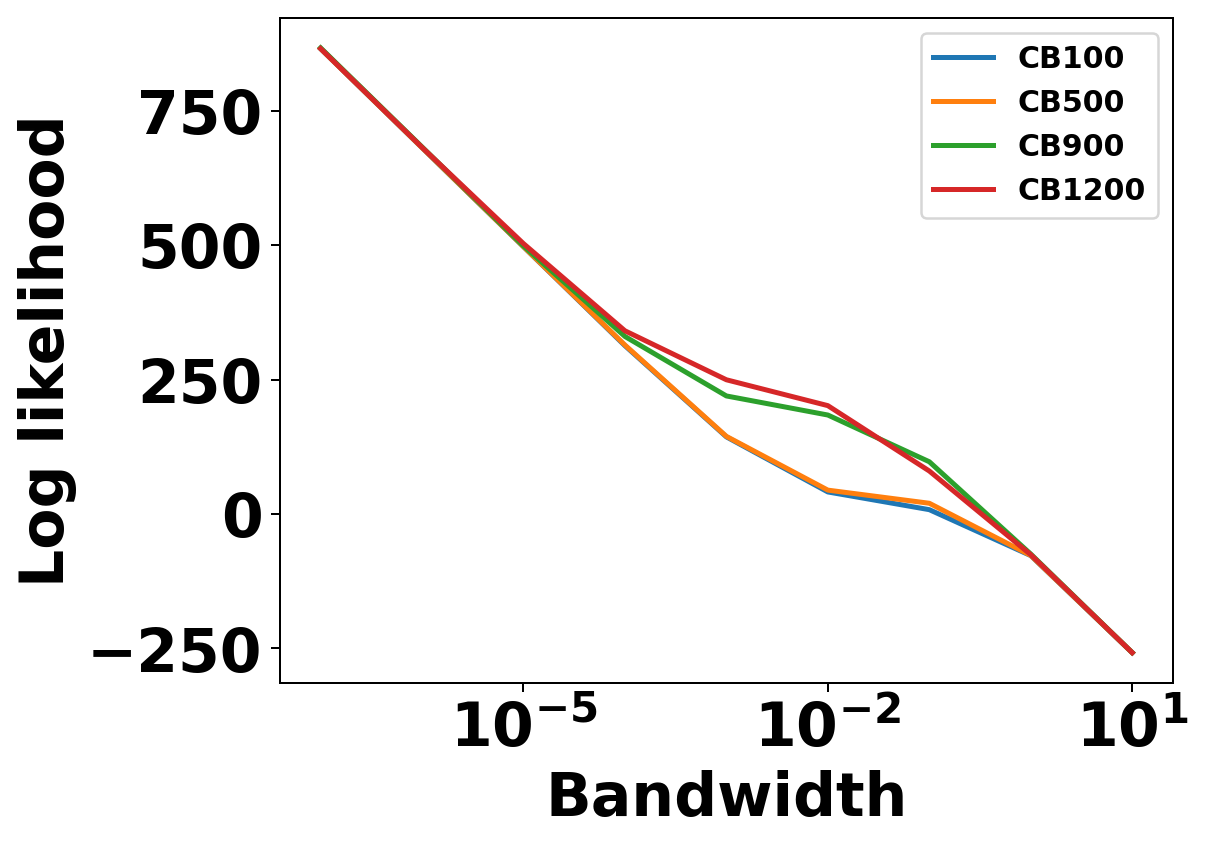

In [9]:
for i in range(len(LL_score)):
    plt.plot(values,np.asarray(LL_score[i]))
plt.legend([ 'CB100', 'CB500', 'CB900', 'CB1200'])  #'water', 'meth',
plt.xlabel('Bandwidth')
plt.ylabel('Log likelihood')
plt.xscale('log')

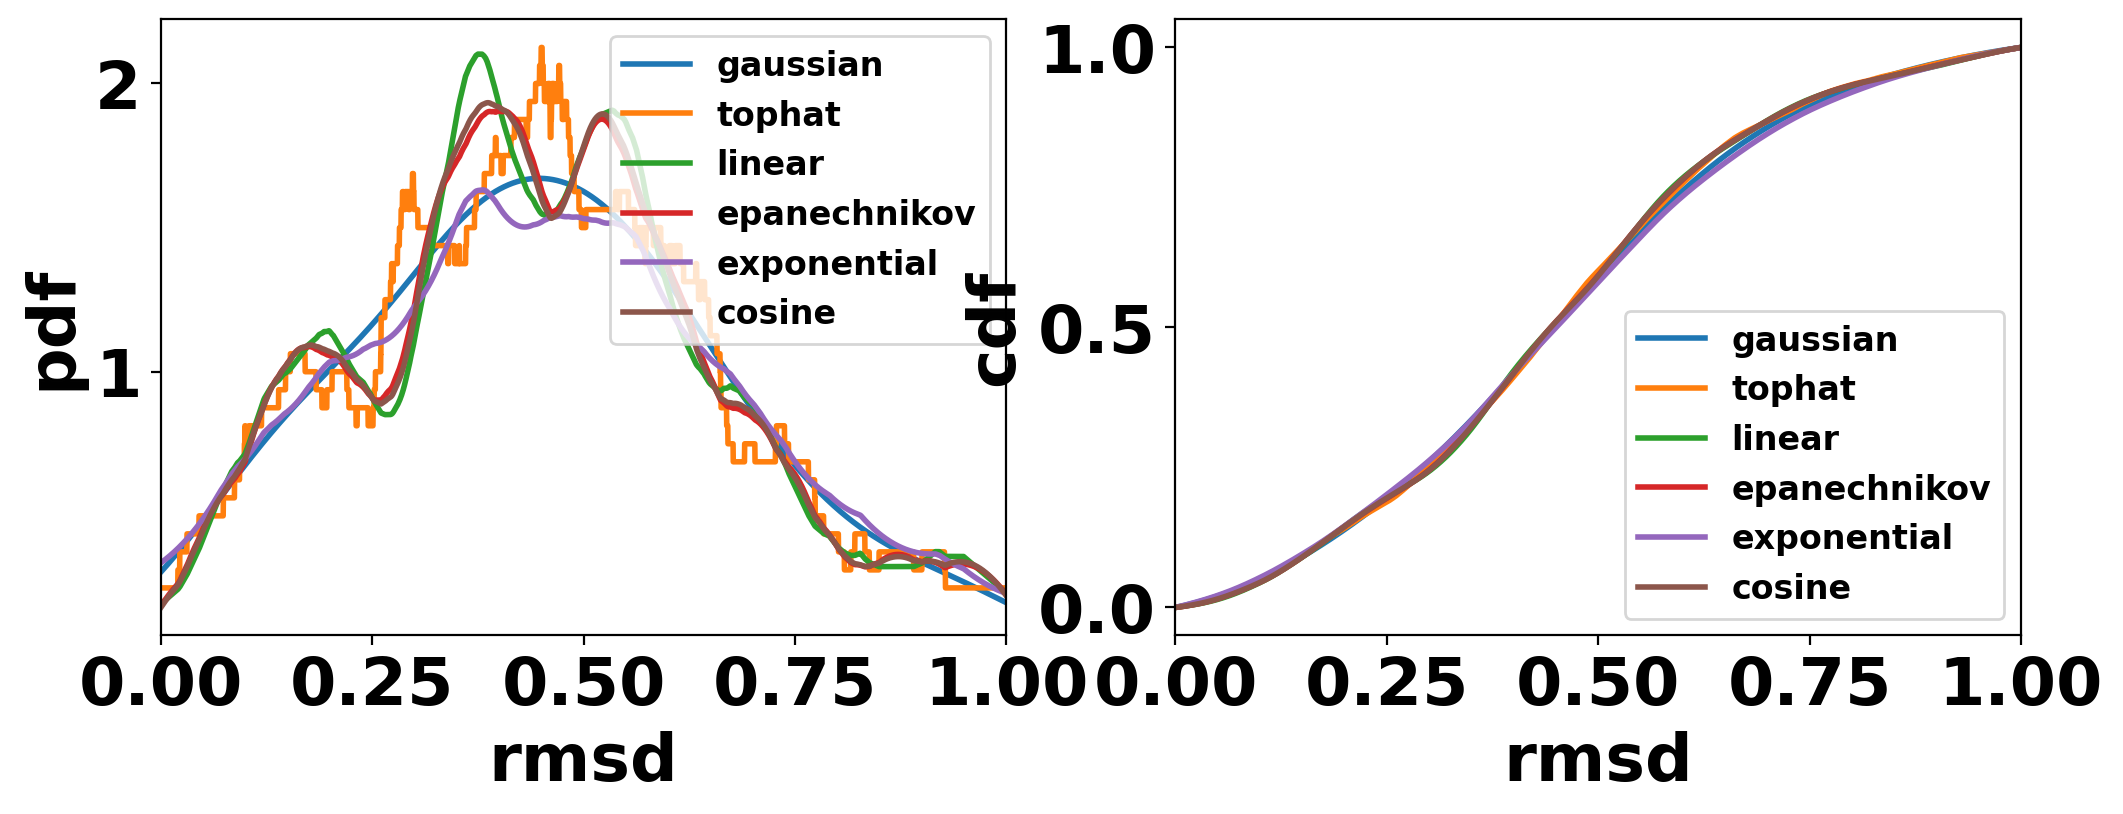

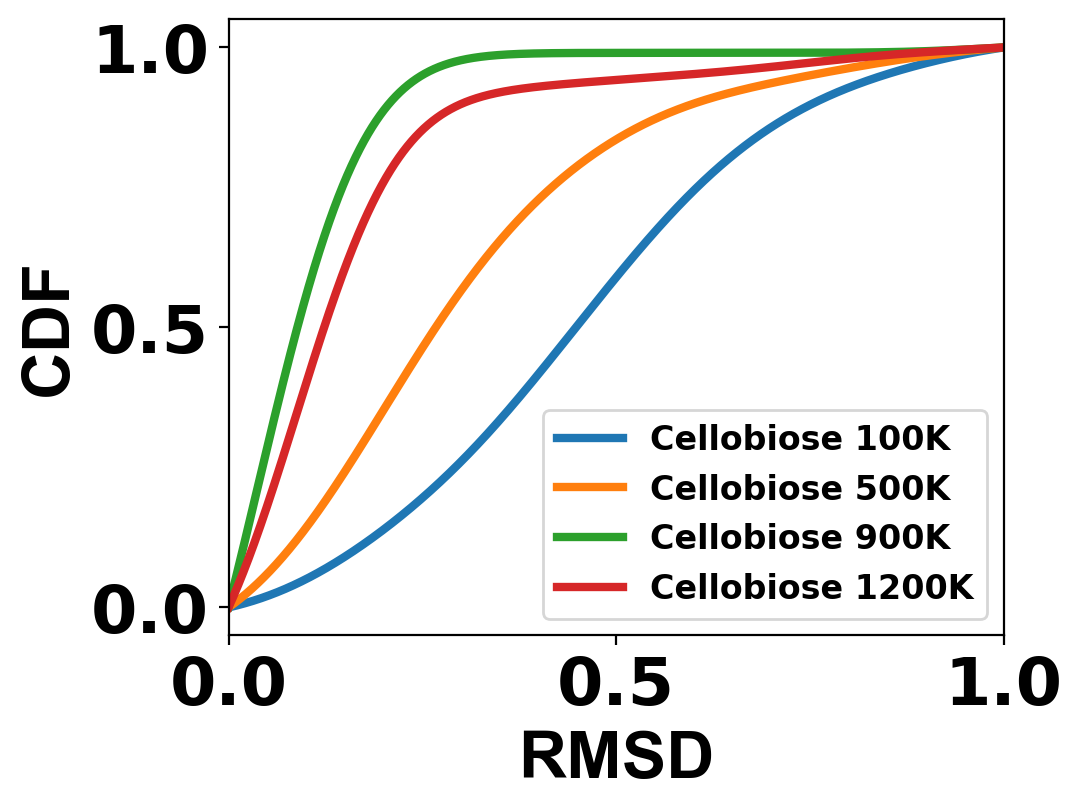

In [10]:
bandwidth=1e-1 #1e-6
u = np.linspace(0, 1, 8000)

ker_list=['gaussian','tophat', 'linear','epanechnikov','exponential', 'cosine']
fig, ax=plt.subplots(1,2, figsize=(12,4),dpi=200)

for i, kernel in enumerate(ker_list):
    scipy_kernel = KernelDensity(kernel=kernel,bandwidth=bandwidth)
    scipy_kernel.fit(rmsd_CB100[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = scipy_kernel.score_samples(u[:, np.newaxis])
    pdf= np.exp(log_pdf)

    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]

    ax[0].plot(u, pdf)
    ax[0].set_xlim([0,1])
    ax[0].set_xlabel('rmsd')
    ax[0].set_ylabel('pdf')

    ax[1].plot(u, cdf)
    ax[1].set_xlim([0,1])
    ax[1].set_xlabel('rmsd')
    ax[1].set_ylabel('cdf')

ax[0].legend(ker_list)  
ax[1].legend(ker_list)


bandwidth=[1e-1,1e-1, 1e-1,1e-1]
data_tot=[rmsd_CB100, rmsd_CB500, rmsd_CB900, rmsd_CB1200] # rmsd_water, rmsd_meth, 
scipy_kernel_list=[]

plot5=plt.figure( figsize=(5,4),dpi=200)

for i, rmsd in enumerate(data_tot):
    scipy_kernel = KernelDensity(kernel='gaussian',bandwidth=bandwidth[i])
    scipy_kernel_list.append(scipy_kernel)
    scipy_kernel.fit(rmsd[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = scipy_kernel.score_samples(u[:, np.newaxis])
    pdf= np.exp(log_pdf)

    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]

    #ax[0].plot(u, pdf)
    #ax[0].set_xlim([0,1])
    #ax[0].set_xlabel('RMSD',fontname='Arial', fontsize=12)
    #ax[0].set_ylabel('PDF',fontname='Arial', fontsize=12)

    plt.plot(u, cdf, linewidth=3)
    plt.xlim([0,1])
    plt.xlabel('RMSD',fontname='Arial')
    plt.ylabel('CDF',fontname='Arial')

#ax[0].legend([ 'Cellobiose 100K', 'Cellobiose 500K', 'Cellobiose 900K', 'Cellobiose 1200K'])  #'Water', 'Methanol',
plt.legend([ 'Cellobiose 100K', 'Cellobiose 500K', 'Cellobiose 900K','Cellobiose 1200K']) # 'Water', 'Methanol',


In [11]:
# compute the posterior probabilities

probab=[]
for rmsd in data_tot:
    c1=np.mean(np.exp(scipy_kernel_list[0].score_samples(rmsd[:, np.newaxis]))) 
    c2=np.mean(np.exp(scipy_kernel_list[2].score_samples(rmsd[:, np.newaxis]))) 
    probab.append((c1/(c1+c2)))

In [12]:
#posterior probabilities that the rmsds come from CB1200 where we may assume there is most reorganization
probab

[0.730914430887832,
 0.4631373330303906,
 0.1122100855101071,
 0.17775581751123423]

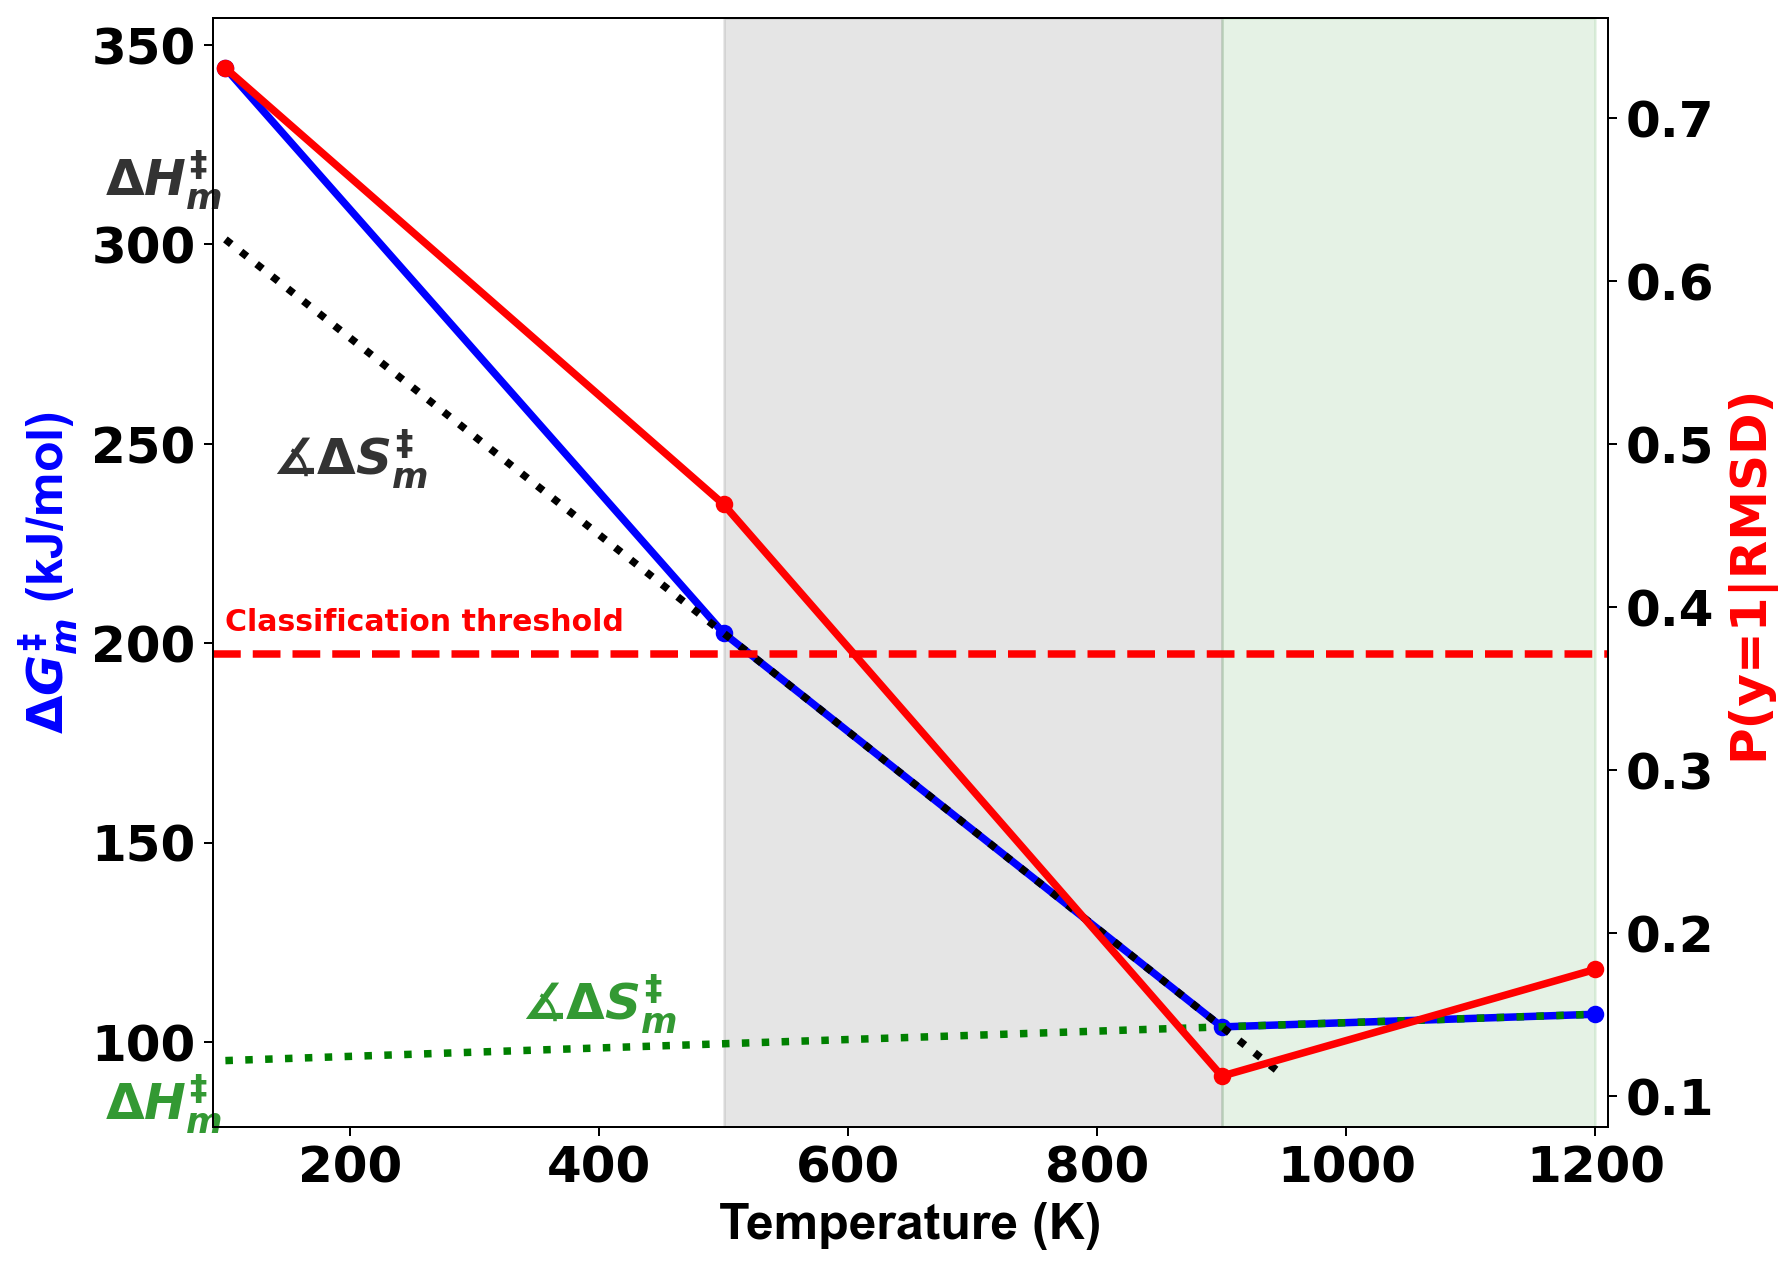

In [13]:
# create figure and axis objects with subplots()
temperature=np.asarray([100, 500, 900, 1200])
gibbs_energy=np.asarray([344.24, 202.52, 103.77, 106.94])

# black fit line
x = np.array([ 500, 900])
y = np.array([202.52, 103.77])

#find line of best fit
a, b = np.polyfit(x, y, 1)


# black fit line
xx = np.array([ 900, 1200])
yy = np.array([103.77, 106.94])

#find line of best fit
aa, bb = np.polyfit(xx, yy, 1)


fig,ax = plt.subplots(figsize=(10,8))
# make a plot

# make a plot with different y-axis using second axis object
ax.plot(temperature, gibbs_energy,color="blue",marker="o", linewidth=3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

ax.plot(temperature, aa*temperature+bb,':g', linewidth=3)        
ax.text(50, bb-10, '$\Delta H_{m}^{\ddag}$', fontsize=20, color='green', va='center', ha='center', alpha=0.8)
ax.text(400, bb+15, '$ \measuredangle \Delta S_{m}^{\ddag}$', fontsize=20, color='green', va='center', ha='center', alpha=0.8)

ax.plot(np.asarray([100, 500, 900, 950]), a*np.asarray([100, 500, 900, 950])+b,':k', linewidth=3 )        
ax.text(50, b-10, '$\Delta H_{m}^{\ddag}$', fontsize=20, color='black', va='center', ha='center', alpha=0.8)
ax.text(200, b-80, '$ \measuredangle \Delta S_{m}^{\ddag}$', fontsize=20, color='black', va='center', ha='center', alpha=0.8)

ax.set_ylabel("$\Delta G_{m}^{\ddag}$ (kJ/mol)",color="blue",fontsize=20, fontname="Arial")


ax.axvspan(500, 900, alpha=0.1, color='black')
ax.axvspan(900, 1200, alpha=0.1, color='green')

ax.set_xlim([90,1210])
ax.set_xlabel("Temperature (K)", fontsize = 20, fontname="Arial")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(temperature,
        probab,
        color="red", 
        marker="o", linewidth=3)
ax2.axhline(y = np.mean(probab), color = 'r', linestyle = '--', linewidth=3)
ax2.text(260, np.mean(probab)+0.02, 'Classification threshold', fontsize=12, color='red', va='center', ha='center')
# set x-axis label
# set y-axis label
ax2.set_ylabel("P(y=1|RMSD)",
              color="red",
              fontsize=20)

plt.yticks(fontsize=20)

plt.show()


In [14]:
#create y labels, class assignment ?
y_label=np.zeros((len(probab),1))
y_label[np.where(np.asarray(probab)>np.mean(probab)),]=1
print(y_label)


[[1.]
 [1.]
 [0.]
 [0.]]
